In [192]:
import requests
import pandas as pd
import json

from sklearn.preprocessing import StandardScaler

import time
import random
import csv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [9]:
def osrs_api(item_id):
    '''Takes an item's id number and returns a pandas data frame with its name and current price'''
    
    item_df = pd.DataFrame()
    url = 'http://services.runescape.com/m=itemdb_oldschool/api/catalogue/detail.json?item='
    response = requests.get(url+item_id)
    data = response.json()
    
    name = data['item']['name']
    
    price = data['item']['current']['price']
    if 'k' in str(price):
        price = float(str(price).replace('k',''))*1000
    elif 'm' in str(price):
        price = float(str(price).replace('m',''))*1000_000
    elif 'b' in str(price):
        price = float(str(price).replace('b',''))*1000_000_000
    else: 
        price = float(str(price).replace(",",""))
        
    item_df['names'] = [name]
    item_df['prices'] = [price]
    
    return item_df

Oldschool Runescape has a list of highest volume items along with indexes of items related to vatious bosses and skills in the game.
https://oldschool.runescape.wiki/w/RuneScape:Grand_Exchange_Market_Watch/High_Trade_Volume_Index#a=30

In [19]:
from osrsbox import items_api
items = items_api.load()
tradable_ge = {}
for item in items:
    if item.tradeable_on_ge == True:
        tradable_ge[item.name] = item.id
    else: 
        continue

In [21]:
list_itm_names = ['Fire rune','Feather','Pure essence',"Zulrah's scales",'Air rune','Water rune','Blood rune','Chaos rune','Death rune','Earth rune','Cannonball','Nature rune','Mind rune','Coal','Adamant dart','Gold ore']

In [28]:
high_vol_item_list = []
for item in list_itm_names:
    high_vol_item_list.append(tradable_ge[item])
    

In [17]:
high_vol_item_list = list(range(554,567,1)) + 

In [160]:
high_vol_item_list[:5]

[554, 314, 7936, 12934, 556]

In [35]:
# https://github.com/chriskok/GEPrediction-OSRS/blob/master/data_scrapers/ge-scraper.py 

full_dict = {}
labels = ['timestamp']

for item_id in high_vol_item_list:
    r = requests.get('http://services.runescape.com/m=itemdb_oldschool/api/graph/{}.json'.format(item_id))
    json_data = json.loads(r.text)
    current_daily_dict = json_data['daily']

    for daily_timestamp in current_daily_dict:
        if (daily_timestamp in full_dict):
            full_dict[daily_timestamp].append(current_daily_dict[daily_timestamp])
        else:
            full_dict[daily_timestamp] = [current_daily_dict[daily_timestamp]]
    
    r2 = requests.get('http://services.runescape.com/m=itemdb_oldschool/api/catalogue/detail.json', params={'item': item_id})
    labels.append(json.loads(r2.text)['item']['name'].replace(" ", "_"))

In [50]:
high_vol_df = pd.DataFrame(full_dict).T

In [55]:
high_vol_df.columns = list_itm_names

In [59]:
high_vol_df.tail()

,Fire rune,Feather,Pure essence,Zulrah's scales,Air rune,Water rune,Blood rune,Chaos rune,Death rune,Earth rune,Cannonball,Nature rune,Mind rune,Coal,Adamant dart,Gold ore
1645747200000,5,3,2,132,4,4,296,64,196,5,158,204,2,167,66,271
1645833600000,5,3,2,135,5,4,299,65,195,5,157,203,2,165,67,278
1645920000000,5,3,2,136,5,5,305,66,196,5,158,204,3,167,67,284
1646006400000,5,3,2,135,5,5,313,66,197,5,157,206,3,168,66,274
1646092800000,5,3,2,134,5,4,310,65,197,5,155,203,3,174,66,270


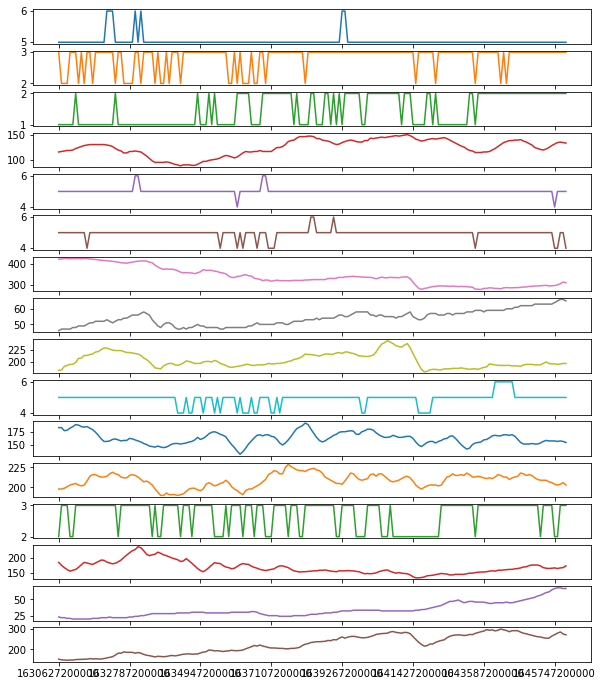

In [61]:
high_vol_df.plot(subplots=True,figsize=(10,12), legend=False);

In [63]:
scaler = StandardScaler()
high_vol_df_ss = scaler.fit_transform(high_vol_df)

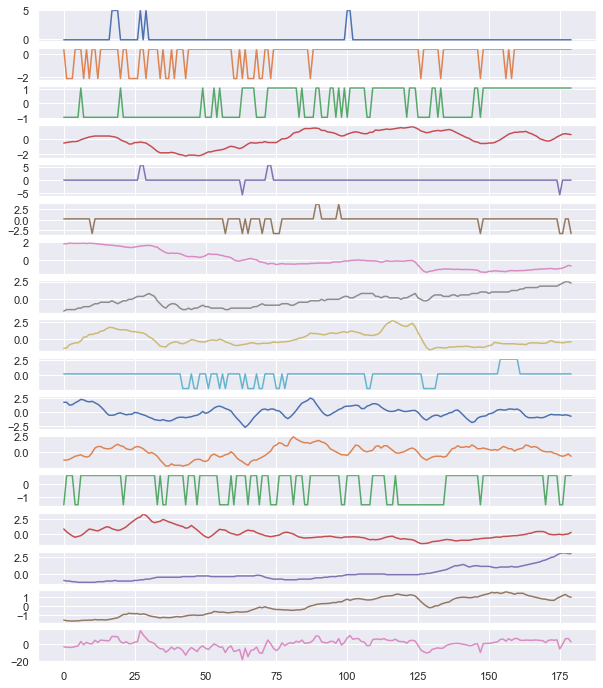

In [205]:
pd.DataFrame(high_vol_df_ss).plot(subplots=True,figsize=(10,12), legend=False);

In [68]:
high_vol_df['index'] = high_vol_df[list_itm_names].sum(axis=1)

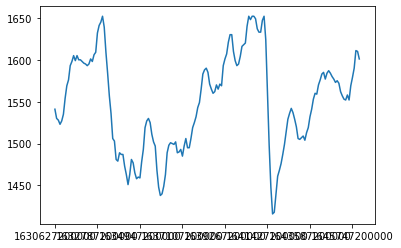

In [72]:
high_vol_df['index'].plot();

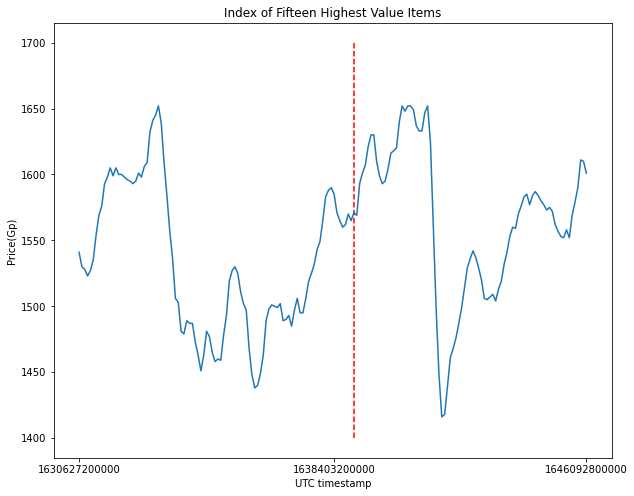

In [139]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(high_vol_df.index, high_vol_df['index'])

plt.xticks(rotation=0,ticks=[0,90,179])
# plt.ylim(4000000,6000000)
plt.yticks()
ax.vlines(x='1639008000000',ymin=1400,ymax=1700,colors='red',linestyles='dashed')

plt.xlabel('UTC timestamp')
plt.ylabel('Price(Gp)')
plt.title('Index of Fifteen Highest Value Items')
plt.show()

In [82]:
high_vol_df_ss = pd.DataFrame(high_vol_df_ss)

In [86]:
high_vol_df_ss['index'] = high_vol_df_ss[range(0,15)].sum(axis=1)

In [98]:
high_vol_df_ss['index']

0     -3.356996
1     -3.986502
2     -4.121099
3     -4.061368
4     -3.165780
         ...   
175   -6.026490
176   -0.359687
177    6.128389
178    6.416772
179    2.317143
Name: index, Length: 180, dtype: float64

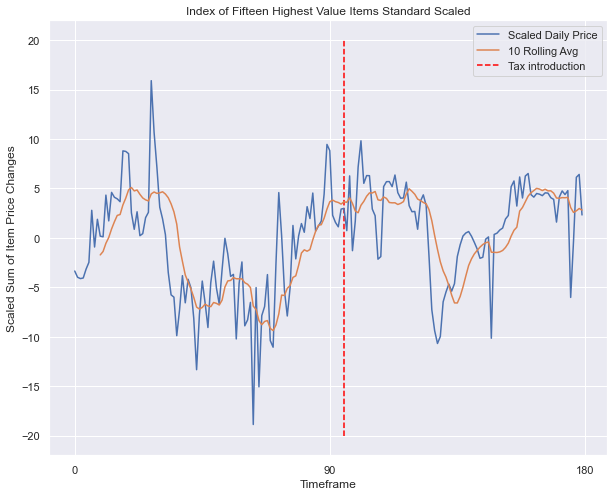

In [202]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(high_vol_df_ss.index, high_vol_df_ss['index'])
ax.plot(high_vol_df_ss.index, high_vol_df_ss.rolling(10).mean()['index'])


plt.xticks(rotation=0,ticks=[0,90,180])
# plt.ylim(4000000,6000000)
plt.yticks()
ax.vlines(x=95,ymin=-20,ymax=20,colors='red',linestyles='dashed')

plt.xlabel('Timeframe')
plt.ylabel('Scaled Sum of Item Price Changes')
plt.title('Index of Fifteen Highest Value Items Standard Scaled')
plt.legend(labels=('Scaled Daily Price','10 Rolling Avg','Tax introduction'))

plt.show()

In [115]:
for i in list_itm_names:
    print(i)

Fire rune
Feather
Pure essence
Zulrah's scales
Air rune
Water rune
Blood rune
Chaos rune
Death rune
Earth rune
Cannonball
Nature rune
Mind rune
Coal
Adamant dart
Gold ore


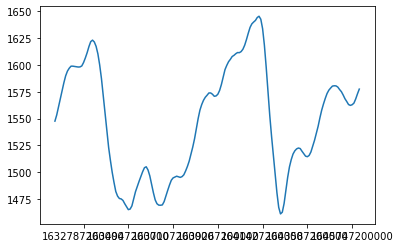

In [131]:
high_vol_df.rolling(10).mean()['index'].plot();

In [149]:
high_vol_df['index'].mean()

1548.6333333333334

In [ ]:
high_vol_df['index'] = high_vol_df[list_itm_names].sum(axis=1)

In [153]:
high_vol_df['diff'] = high_vol_df['index'] - 1548.6333333333334

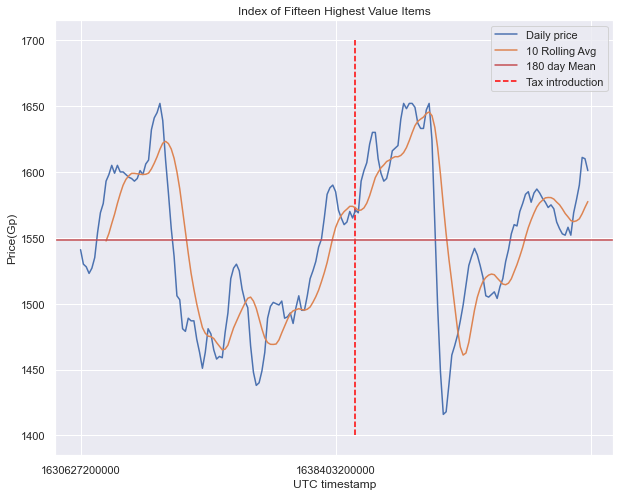

In [201]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(high_vol_df.index, high_vol_df['index'])
ax.plot(high_vol_df.index, high_vol_df.rolling(10).mean()['index'])
plt.axhline(y = 1548.6333333333334, color = 'r', linestyle = '-')


plt.xticks(rotation=0,ticks=[0,90,180])
# plt.ylim(4000000,6000000)
plt.yticks()
ax.vlines(x='1639008000000',ymin=1400,ymax=1700,colors='red',linestyles='dashed')

plt.xlabel('UTC timestamp')
plt.ylabel('Price(Gp)')
plt.title('Index of Fifteen Highest Value Items')
plt.legend(labels=('Daily price','10 Rolling Avg','180 day Mean','Tax introduction'))
plt.show()

In [156]:
ax.plot(high_vol_df.index, high_vol_df['diff'])

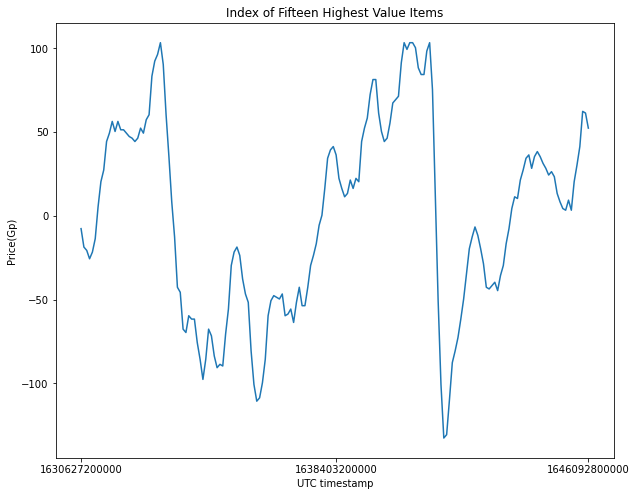

In [159]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(high_vol_df.index, high_vol_df['diff'])
plt.xticks(rotation=0,ticks=[0,90,179])
# plt.ylim(4000000,6000000)
plt.yticks()
# ax.vlines(x='1639008000000',ymin=1400,ymax=1700,colors='red',linestyles='dashed')

plt.xlabel('UTC timestamp')
plt.ylabel('Price(Gp)')
plt.title('Index of Fifteen Highest Value Items')
plt.show()

In [173]:
high_vol_df_ss.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,index
0,1.000000,0.018373,-0.134874,0.026343,0.145422,0.035375,0.228097,0.007778,0.246610,0.047012,0.002403,0.086494,0.128210,0.203425,-0.142168,-0.128886,0.349301
1,0.018373,1.000000,0.182948,0.231856,0.028351,0.122662,-0.255515,0.254744,0.107394,0.071117,0.066178,0.264191,-0.007837,-0.271313,0.223892,0.291086,0.374790
2,-0.134874,0.182948,1.000000,0.327062,-0.058319,-0.027384,-0.489078,0.450174,0.056542,0.140977,-0.012219,0.281918,0.020722,-0.319116,0.423110,0.577899,0.338990
3,0.026343,0.231856,0.327062,1.000000,-0.035403,0.131841,-0.390708,0.493301,0.389474,0.234531,0.360329,0.616017,-0.127135,-0.603638,0.195800,0.576115,0.524304
4,0.145422,0.028351,-0.058319,-0.035403,1.000000,0.225174,0.101480,-0.052048,0.061190,0.089689,0.087151,0.099209,0.038862,0.158422,-0.172505,-0.078181,0.315847
5,0.035375,0.122662,-0.027384,0.131841,0.225174,1.000000,0.041645,-0.000407,0.163517,0.249025,0.107971,0.123799,0.189693,-0.040470,-0.130555,0.026304,0.403280
6,0.228097,-0.255515,-0.489078,-0.390708,0.101480,0.041645,1.000000,-0.584407,0.376833,-0.063899,0.234722,-0.239656,0.076440,0.666009,-0.725244,-0.834743,-0.004283
7,0.007778,0.254744,0.450174,0.493301,-0.052048,-0.000407,-0.584407,1.000000,-0.008635,0.342628,-0.144570,0.370463,0.082176,-0.249205,0.814553,0.772595,0.510850
8,0.246610,0.107394,0.056542,0.389474,0.061190,0.163517,0.376833,-0.008635,1.000000,0.112148,0.355445,0.349923,-0.076569,0.078385,-0.385134,0.018044,0.520156
9,0.047012,0.071117,0.140977,0.234531,0.089689,0.249025,-0.063899,0.342628,0.112148,1.000000,0.204504,0.336288,0.275682,-0.010065,0.189771,0.274295,0.592331


### Correlation Matrix for top volume items in OSRS

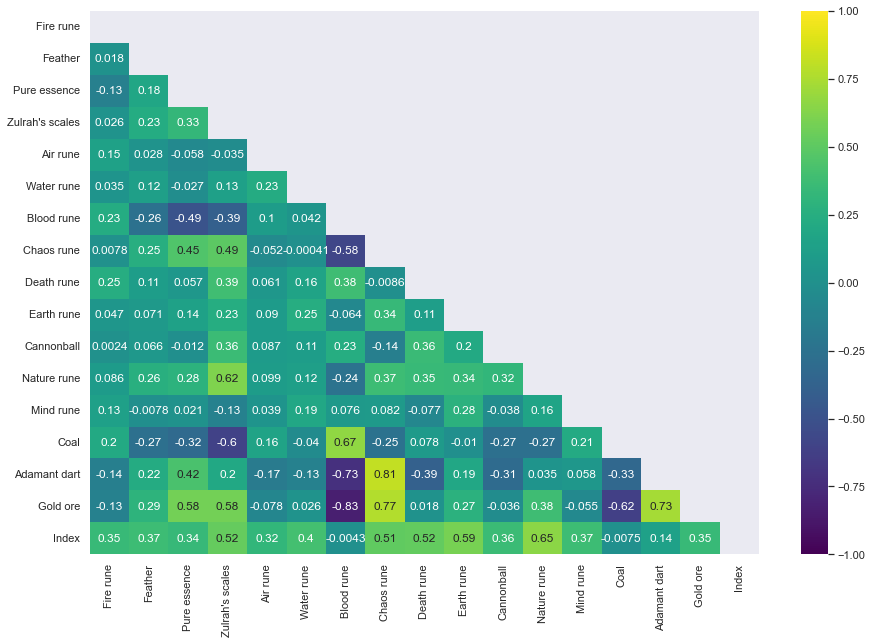

In [ ]:
sns.set(rc = {'figure.figsize':(15,10)})

#https://seaborn.pydata.org/examples/many_pairwise_correlations.html
mask = np.triu(np.ones_like(high_vol_df_ss.corr(), dtype=bool))

sns.heatmap(high_vol_df_ss.corr(),vmin=-1,vmax=1,cmap='viridis', annot=True,xticklabels=list_itm_names+['Index'],yticklabels=list_itm_names+['Index'],mask=mask);

In [206]:
from statsmodels.tsa.stattools import adfuller
adfuller(high_vol_df['index'])


(-3.6586256958059855,
 0.004734225951002264,
 1,
 178,
 {'1%': -3.467631519151906,
  '5%': -2.8779183721695567,
  '10%': -2.575501353364474},
 1230.7662960177358)

In [211]:
# Code written by Joseph Nelson in GA notebook
pd.Series(adfuller(high_vol_df['index'])[0:2], index=['Test Statistic','p-value'])

Test Statistic   -3.658626
p-value           0.004734
dtype: float64

In [214]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split


In [215]:
y_train, y_test = train_test_split(high_vol_df['index'],test_size = 0.1,shuffle = False)

In [216]:
y_train

1630627200000    1541
1630713600000    1530
1630800000000    1528
1630886400000    1523
1630972800000    1527
                 ... 
1644192000000    1583
1644278400000    1585
1644364800000    1577
1644451200000    1584
1644537600000    1587
Name: index, Length: 162, dtype: int64

In [217]:
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p},1,{q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
                          order = (p,1,q)) # values of p, d, q
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0,1,0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06359D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   4.064D+00
  F =   4.0635871407989992     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The AIC for ARIMA(0,1,0) is: 1312.4750593372778
Attempting to fit ARIMA(0,1,1)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =     

/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was pro

Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   8.882D-08   3.757D+00
  F =   3.7574816039124492     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(0,1,2) is: 1217.9090764598086
Attempting to fit ARIMA(0,1,3)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73839D+00    |proj g|=  1.98423D-03

At iterate    5    f=  3.73836D+00    |proj g|=  2.41185D-04

At iterate   10    f=  3.73834D+00    |proj g|=  1.16795D-05

           * * *

Tit   = total number of it

/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnin

The AIC for ARIMA(0,1,4) is: 1212.2435987859135
Attempting to fit ARIMA(1,1,0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75292D+00    |proj g|=  6.88383D-04

At iterate    5    f=  3.75287D+00    |proj g|=  1.89817D-03

At iterate   10    f=  3.75285D+00    |proj g|=  1.33227D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     15      1     0     0   8.882D-08   3.753D+00
  F =   3.7528467524052420     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH     

/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnin


At iterate   10    f=  3.73599D+00    |proj g|=  2.88125D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   4.441D-08   3.736D+00
  F =   3.7359848100523307     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(1,1,2) is: 1212.9871088368504
Attempting to fit ARIMA(1,1,3)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73078D+00    |proj g|=  3.64708D-03

At iterate    5    f=  3.73076D+00    |proj g|=  6.2

/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72729D+00    |proj g|=  4.36948D-03

At iterate    5    f=  3.72723D+00    |proj g|=  3.00959D-04

At iterate   10    f=  3.72723D+00    |proj g|=  1.16085D-04

At iterate   15    f=  3.72723D+00    |proj g|=  2.72271D-04

At iterate   20    f=  3.72723D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     28      1     0     0   1.332D-07   3.727D+00
  F =   3.7272267811344486     

CONVERG

 This problem is unconstrained.
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74712D+00    |proj g|=  1.69282D-03

At iterate    5    f=  3.74710D+00    |proj g|=  1.13483D-03

At iterate   10    f=  3.74708D+00    |proj g|=  7.68274D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     19      1     0     0   0.000D+00   3.747D+00
  F =   3.7470811097069010     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The AIC for ARIMA(2,1,0) is: 1214.560117325622
Attempting to fit ARIMA

 This problem is unconstrained.
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.



At iterate    5    f=  3.72158D+00    |proj g|=  2.36873D-03

At iterate   10    f=  3.72156D+00    |proj g|=  1.03704D-03

At iterate   15    f=  3.72155D+00    |proj g|=  2.62590D-04

At iterate   20    f=  3.72155D+00    |proj g|=  1.12399D-04

At iterate   25    f=  3.72155D+00    |proj g|=  5.01821D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     33      1     0     0   1.332D-07   3.722D+00
  F =   3.7215494907418205     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(2,1,3) is: 1212.3389360188662
Attempting to fit ARIMA(2,1,4)


/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72026D+00    |proj g|=  4.63629D-03

At iterate    5    f=  3.72005D+00    |proj g|=  5.64397D-03

At iterate   10    f=  3.71980D+00    |proj g|=  1.89804D-04

At iterate   15    f=  3.71980D+00    |proj g|=  6.15197D-04

At iterate   20    f=  3.71980D+00    |proj g|=  8.33555D-05

At iterate   25    f=  3.71979D+00    |proj g|=  1.77502D-04

At iterate   30    f=  3.71979D+00    |proj g|=  6.22169D-05

At iterate   35    f=  3.71979D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnin


At iterate   10    f=  3.72646D+00    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     17      1     0     0   4.441D-08   3.726D+00
  F =   3.7264578335849698     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(3,1,0) is: 1209.9194224143603
Attempting to fit ARIMA(3,1,1)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72290D+00    |proj g|=  3.89035D-03

At iterate    5    f=  3.72276D+00    |proj g|=  2.8

/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72267D+00    |proj g|=  3.31282D-03

At iterate    5    f=  3.72251D+00    |proj g|=  3.09104D-03

At iterate   10    f=  3.72241D+00    |proj g|=  4.47642D-05

At iterate   15    f=  3.72241D+00    |proj g|=  6.60361D-05

At iterate   20    f=  3.72241D+00    |proj g|=  1.69642D-05

At iterate   25    f=  3.72241D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     34      1     0     0   

/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72212D+00    |proj g|=  3.61435D-03

At iterate    5    f=  3.72207D+00    |proj g|=  6.50369D-04

At iterate   10    f=  3.72200D+00    |proj g|=  8.04201D-04

At iterate   15    f=  3.72190D+00    |proj g|=  2.08140D-03

At iterate   20    f=  3.72182D+00    |proj g|=  2.46652D-03

At iterate   25    f=  3.72178D+00    |proj g|=  2.30926D-05

At iterate   30    f=  3.72178D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.



At iterate   15    f=  3.71974D+00    |proj g|=  5.31131D-04

At iterate   20    f=  3.71974D+00    |proj g|=  1.73239D-04

At iterate   25    f=  3.71974D+00    |proj g|=  2.28573D-04

At iterate   30    f=  3.71974D+00    |proj g|=  7.54952D-07

At iterate   35    f=  3.71974D+00    |proj g|=  1.33227D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     36     41      1     0     0   1.332D-07   3.720D+00
  F =   3.7197358814034511     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(3,1,4) is: 1215.7549538119113
Attempting to fit ARIMA(4,1,0)
RUNNING THE L-BFGS-B CODE

       

/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72023D+00    |proj g|=  4.02869D-03

At iterate    5    f=  3.71922D+00    |proj g|=  9.72360D-03

At iterate   10    f=  3.71333D+00    |proj g|=  1.37761D-02

At iterate   15    f=  3.71123D+00    |proj g|=  2.97278D-03

At iterate   20    f=  3.71097D+00    |proj g|=  7.90923D-04

At iterate   25    f=  3.71095D+00    |proj g|=  5.97300D-05

At iterate   30    f=  3.71095D+00    |proj g|=  4.17444D-06

At iterate   35    f=  3.71095D+00    |proj g|=  2.04281D-06

At iterate   40    f=  3.71095D+00    |proj g|=  3.64153D-06

At iterate   45    f=  3.71095D+00    |proj g|=  5.32907D-06

At iterate   50    f=  3.71095D+00    |proj g|=  3.10862D-06

At iterate   55    f=  3.71095D+00    |proj g|=  3.95239D-06

At iterate   60    f=  3.71095D+00    |proj g|=  2.14495D-05

           * * *

Tit   = 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72201D+00    |proj g|=  2.04667D-03

At iterate    5    f=  3.72184D+00    |proj g|=  2.73457D-03

At iterate   10    f=  3.72169D+00    |proj g|=  1.48153D-03

At iterate   15    f=  3.72139D+00    |proj g|=  1.27089D-03

At iterate   20    f=  3.72138D+00    |proj g|=  3.25473D-04

At iterate   25    f=  3.72138D+00    |proj g|=  1.04805D-05

At iterate   30    f=  3.72138D+00    |proj g|=  1.06581D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68923D+00    |proj g|=  3.18887D-01

At iterate    5    f=  3.67913D+00    |proj g|=  6.21238D-02

At iterate   10    f=  3.67663D+00    |proj g|=  4.32036D-02

At iterate   15    f=  3.67615D+00    |proj g|=  3.16254D-03

At iterate   20    f=  3.67603D+00    |proj g|=  3.96438D-04

At iterate   25    f=  3.67603D+00    |proj g|=  2.22045D-07


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     34      1     0     0   8.882D-08   3.676D+00
  F =   3.6760325584225759     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(4,1,3) is: 1201.6824838120694
Attempting to fit ARIMA(4,1,4)


/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69593D+00    |proj g|=  1.19961D-02

At iterate    5    f=  3.69548D+00    |proj g|=  1.89118D-02

At iterate   10    f=  3.69444D+00    |proj g|=  5.47513D-03

At iterate   15    f=  3.69394D+00    |proj g|=  6.05991D-03

At iterate   20    f=  3.69388D+00    |proj g|=  2.65326D-03


 This problem is unconstrained.



At iterate   25    f=  3.69384D+00    |proj g|=  2.71116D-04

At iterate   30    f=  3.69383D+00    |proj g|=  2.26690D-03

At iterate   35    f=  3.69382D+00    |proj g|=  3.09353D-04

At iterate   40    f=  3.69382D+00    |proj g|=  4.57412D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     44     52      1     0     0   2.220D-07   3.694D+00
  F =   3.6938235685552532     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(4,1,4) is: 1209.4111890747915


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(4,1,3).
This model has an AIC of 1201.68248381

In [ ]:
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(4,1,3).
This model has an AIC of 1201.6824838120694.

In [327]:
model = ARIMA(endog = y_train.astype(float).dropna(),order = (3,1,2))

arima = model.fit()

/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/brockbigalke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was pro

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72267D+00    |proj g|=  3.31282D-03

At iterate    5    f=  3.72251D+00    |proj g|=  3.09104D-03

At iterate   10    f=  3.72241D+00    |proj g|=  4.47642D-05

At iterate   15    f=  3.72241D+00    |proj g|=  6.60361D-05

At iterate   20    f=  3.72241D+00    |proj g|=  1.69642D-05

At iterate   25    f=  3.72241D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     34      1     0     0   

In [328]:
# preds = model.predict(y_test)

In [329]:
preds = model.predict(y_test)

In [330]:
pd.DataFrame(preds).dropna()

,0
0,1.584000e+03
1,2.400309e+03
2,8.360469e+04
3,-3.743874e+06
4,-7.453196e+06
...,...
95,-3.519219e+06
96,-3.421190e+06
97,-5.604492e+05
98,-3.529028e+06


In [331]:
pd.DataFrame(preds).set_index(list(pd.DataFrame(y_test).index[-161:]))

KeyError: "None of ['1644624000000', '1644710400000', '1644796800000', '1644883200000', '1644969600000', '1645056000000', '1645142400000', '1645228800000', '1645315200000', '1645401600000', '1645488000000', '1645574400000', '1645660800000', '1645747200000', '1645833600000', '1645920000000', '1646006400000', '1646092800000'] are in the columns"

In [332]:
y_test.index[0]

'1644624000000'

In [333]:
y_test.index[-1]

'1646092800000'

In [334]:
model.predict(params = arima.params,start = pd.DataFrame(y_test).index[0],end = pd.DataFrame(y_test).index[-1])

KeyError: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'

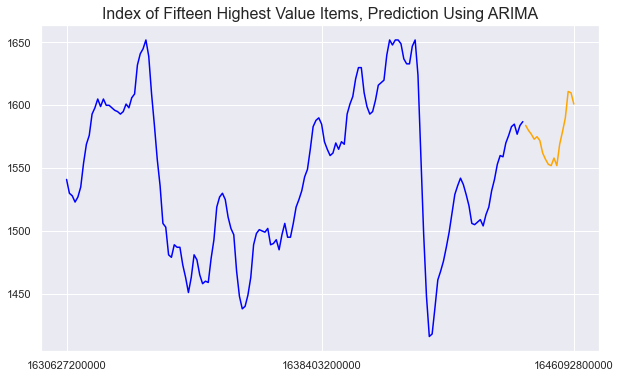

In [337]:
plt.figure(figsize=(10,6))

# plt.plot(high_vol_df.index, high_vol_df['index'])

plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')

plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

# plt.plot(y_test.index[19:], preds, color = 'green')

plt.xticks(rotation=0,ticks=[0,90,179])
plt.title(label = 'Index of Fifteen Highest Value Items, Prediction Using ARIMA', fontsize=16)
plt.show();